In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer

In [7]:
#LOAD DATA
df = pd.read_excel("CodeCraft ML Competition Dataset.xlsx", sheet_name="Sheet1")

In [9]:
df.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes


In [12]:
#DATA CLEANING
for col in ['Average_Cost', 'Minimum_Order']:
    df[col] = (
        df[col]
        .str.replace('₹', '', regex=False)
        .str.replace(',', '', regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

#Clean 'Delivery_Time' (extract numeric part)
df['Delivery_Time'] = df['Delivery_Time'].str.extract(r'(\d+)')[0]
df['Delivery_Time'] = pd.to_numeric(df['Delivery_Time'], errors='coerce')

#Convert 'Rating', 'Votes', 'Reviews' to numeric
df['Rating']  = pd.to_numeric(df['Rating'], errors='coerce')
df['Votes']   = pd.to_numeric(df['Votes'],  errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

#Fill missing numeric values with medians
numeric_cols = ['Average_Cost', 'Minimum_Order', 'Rating', 'Votes', 'Reviews', 'Delivery_Time']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


In [14]:
df.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200.0,50,3.5,12.0,4.0,30
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100.0,50,3.5,11.0,4.0,30
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150.0,50,3.6,99.0,30.0,65
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250.0,99,3.7,176.0,95.0,30
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200.0,99,3.2,521.0,235.0,65


In [16]:
#FEATURE ENGINEERING
#Extract 'City' from 'Location'
df['City'] = df['Location'].str.split(',').str[-1].str.strip()

#Multi-hot encode all cuisines (instead of just primary)
df['Cuisine_List'] = df['Cuisines'].str.split(',').apply(lambda lst: [c.strip() for c in lst] if isinstance(lst, list) else [])
mlb = MultiLabelBinarizer()
cuisine_dummies = pd.DataFrame(
    mlb.fit_transform(df['Cuisine_List']),
    columns=[f"Cuisine_{c}" for c in mlb.classes_],
    index=df.index
)

#Drop unused columns
df_clean = df.drop(columns=['Restaurant', 'Location', 'Cuisines', 'Cuisine_List'])

#Concatenate cuisine multi-hot and one-hot encode 'City'
df_clean = pd.concat([df_clean, cuisine_dummies], axis=1)
df_model = pd.get_dummies(df_clean, columns=['City'])

In [18]:
df.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,City,Cuisine_List
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200.0,50,3.5,12.0,4.0,30,Pune,"[Fast Food, Rolls, Burger, Salad, Wraps]"
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100.0,50,3.5,11.0,4.0,30,Marathalli,"[Ice Cream, Desserts]"
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150.0,50,3.6,99.0,30.0,65,Mumbai Central,"[Italian, Street Food, Fast Food]"
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250.0,99,3.7,176.0,95.0,30,Noida,"[Mughlai, North Indian, Chinese]"
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200.0,99,3.2,521.0,235.0,65,Whitefield,"[Cafe, Beverages]"


In [20]:
#PREPARE MODEL DATA
X = df_model.drop(columns=['Average_Cost', 'Minimum_Order'])
y = df_model['Average_Cost']
#TRAIN-TEST SPLIT (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [22]:
#HYPERPARAMETER TUNING (GridSearchCV)
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2', 10, None],   # “auto” removed
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_base = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [23]:
#MODEL EVALUATION (Regression Metrics)
y_train_pred = best_rf.predict(X_train)
y_test_pred  = best_rf.predict(X_test)

train_mse  = mean_squared_error(y_train,    y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae  = mean_absolute_error(y_train,   y_train_pred)
train_r2   = r2_score(y_train,             y_train_pred)

test_mse  = mean_squared_error(y_test,    y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae  = mean_absolute_error(y_test,   y_test_pred)
test_r2   = r2_score(y_test,             y_test_pred)

print("=== Best Hyperparameters ===")
print(grid_search.best_params_)

print("\n=== TRAIN SET METRICS ===")
print(f"Train R²   : {train_r2:.4f}")
print(f"Train RMSE : {train_rmse:.2f}")
print(f"Train MAE  : {train_mae:.2f}")

print("\n=== TEST SET METRICS ===")
print(f"Test R²   : {test_r2:.4f}")
print(f"Test RMSE : {test_rmse:.2f}")
print(f"Test MAE  : {test_mae:.2f}")

=== Best Hyperparameters ===
{'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

=== TRAIN SET METRICS ===
Train R²   : 0.9450
Train RMSE : 30.23
Train MAE  : 19.29

=== TEST SET METRICS ===
Test R²   : 0.6287
Test RMSE : 80.42
Test MAE  : 48.19


In [29]:
#PREDICTION FUNCTION
feature_cols = X.columns.tolist()

def predict_optimal_price():
    user_city = input("Enter the city: ").strip()
    user_cuisine = input("Enter one or more cuisines (comma-separated): ").strip().split(',')
    user_cuisine = [c.strip() for c in user_cuisine]
    user_rating = float(input("Enter desired rating (e.g., 4.2): ").strip())
    
    # Build a zero-filled input row
    input_row = pd.DataFrame(0, index=[0], columns=feature_cols)
    input_row.at[0, 'Rating'] = user_rating
    input_row.at[0, 'Votes']  = df['Votes'].median()
    input_row.at[0, 'Reviews'] = df['Reviews'].median()
    input_row.at[0, 'Delivery_Time'] = df['Delivery_Time'].median()
    
    # One-hot encode city
    city_col = f"City_{user_city}"
    if city_col in feature_cols:
        input_row.at[0, city_col] = 1
    else:
        print(f"Warning: City '{user_city}' not found in training data.")
    
    # Multi-hot encode cuisines
    for cuisine in user_cuisine:
        cuisine_col = f"Cuisine_{cuisine}"
        if cuisine_col in feature_cols:
            input_row.at[0, cuisine_col] = 1
        else:
            print(f"Warning: Cuisine '{cuisine}' not found in training data.")
    
    # Predict
    pred_price = best_rf.predict(input_row)[0]
    print(f"\nRecommended Average Cost: ₹{pred_price:.2f}")

# run predict_optimal_price() in the next cell 

In [31]:
predict_optimal_price()

Enter the city:  Noida
Enter one or more cuisines (comma-separated):  North Indian
Enter desired rating (e.g., 4.2):  4.1



Recommended Average Cost: ₹189.85


C:\Users\aadik\AppData\Local\Temp\ipykernel_20820\1004031360.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_row.at[0, 'Rating'] = user_rating


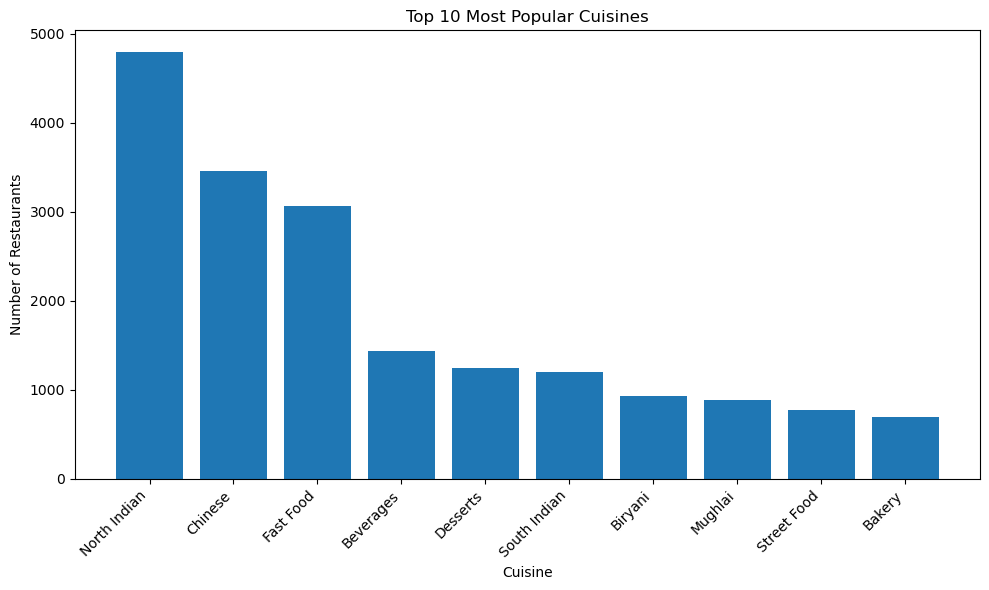

In [33]:
# 1. Load dataset (ensure the file is in your working directory)
df = pd.read_excel("CodeCraft ML Competition Dataset.xlsx", sheet_name="Sheet1")

# 2. Extract list of cuisines for each restaurant
df['Cuisine_List'] = df['Cuisines'].str.split(',').apply(
    lambda lst: [c.strip() for c in lst] if isinstance(lst, list) else []
)

# 3. Flatten the list to count occurrences of each cuisine
all_cuisines = [cuisine for sublist in df['Cuisine_List'] for cuisine in sublist]
cuisine_counts = pd.Series(all_cuisines).value_counts()

# 4. Select top 10 most popular cuisines
top_cuisines = cuisine_counts.head(10)

# 5. Plot the top cuisines as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_cuisines.index, top_cuisines.values)
plt.title("Top 10 Most Popular Cuisines")
plt.xlabel("Cuisine")
plt.ylabel("Number of Restaurants")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
best_rf = grid_search.best_estimator_



In [25]:
feature_cols = X.columns.tolist()  


In [26]:
import pickle

with open("best_rf.pkl", "wb") as f:
    pickle.dump(best_rf, f)

with open("feature_cols.pkl", "wb") as f:
    pickle.dump(feature_cols, f)
